In [25]:
import matplotlib.pyplot as plt
import numpy as np

from checking_tools import checkLabels, checkNormals
from Trefft_tools import TrefftzSpace, TrefftzFunction,  AssembleRHS, AssembleMatrix
from geometry_tools import Edge
from meshes import testMesh, toyMesh, waveguideMesh
from meshes import ScattererType

In [26]:
R = 10.
H = 1.
rad = 0.2

c = (0,0)

quad = False
#Omega = waveguideMesh(rad = rad, scatterer_type=ScattererType.SOUND_SOFT)
#Omega = waveguideMesh(R = R, H = H, c=c, rad = rad,  scatterer_type=ScattererType.SOUND_SOFT,  quad=quad)


Omega = testMesh( h_max= 2*H/3, quad=quad)
# #Omega = toyMesh(quad=quad)

In [27]:
Edges = [ Edge(Omega, e)  for e in Omega.edges ]

Checking the orientation of the labels...

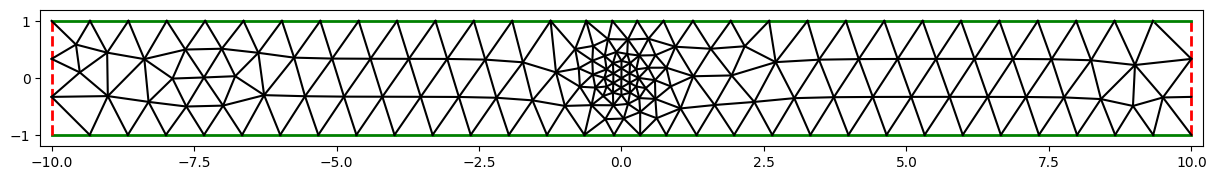

In [11]:
checkLabels(Edges)

and the orientation of the normals...

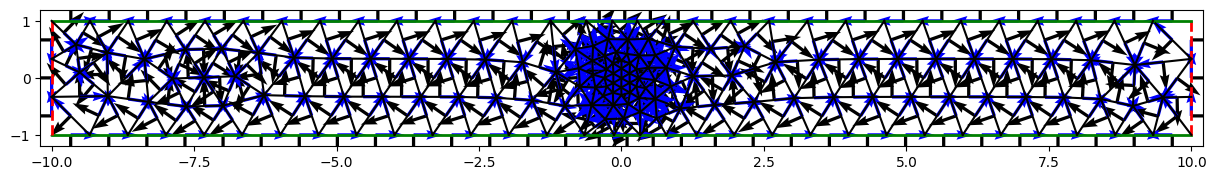

In [12]:
checkNormals(Edges)

and the definition of the "plus" and "minus" quantities...

In [13]:
  # checkPlusMinus(Edges, Baricenters) 

In [14]:
kappa_e = 20.
kappa_i = 5.


In [15]:
# #optimal angle for mode "t" : th = arcsin( lambda /  (2H)) 
# t = 2
# dth = np.arcsin( t*np.pi / (kappa_e*H))
# # optimal number of waves for mode "t":
# Nth = int(2*np.pi / dth)
# Nth 

In [16]:
Nth = 20
th = np.e/10
th = 0.
V = TrefftzSpace(Omega, Nth, {"Omega_i" : kappa_i , "Omega_e" : kappa_e}, th )


In [19]:
V.TestFunctions

[TestFunction(k=20.0, d=array([1., 0.])),
 TestFunction(k=20.0, d=array([0.95105652, 0.30901699])),
 TestFunction(k=20.0, d=array([0.80901699, 0.58778525])),
 TestFunction(k=20.0, d=array([0.58778525, 0.80901699])),
 TestFunction(k=20.0, d=array([0.30901699, 0.95105652])),
 TestFunction(k=20.0, d=array([6.123234e-17, 1.000000e+00])),
 TestFunction(k=20.0, d=array([-0.30901699,  0.95105652])),
 TestFunction(k=20.0, d=array([-0.58778525,  0.80901699])),
 TestFunction(k=20.0, d=array([-0.80901699,  0.58778525])),
 TestFunction(k=20.0, d=array([-0.95105652,  0.30901699])),
 TestFunction(k=20.0, d=array([-1.0000000e+00,  1.2246468e-16])),
 TestFunction(k=20.0, d=array([-0.95105652, -0.30901699])),
 TestFunction(k=20.0, d=array([-0.80901699, -0.58778525])),
 TestFunction(k=20.0, d=array([-0.58778525, -0.80901699])),
 TestFunction(k=20.0, d=array([-0.30901699, -0.95105652])),
 TestFunction(k=20.0, d=array([-1.8369702e-16, -1.0000000e+00])),
 TestFunction(k=20.0, d=array([ 0.30901699, -0.95105

In [25]:
# Testing vector thingys
Edge_dtype = np.dtype([("M", (np.float64,2)),("l", np.float64),("N", (np.float64,2) ),("T", (np.float64,2))])

edges = np.array( [( E.M, E.l, E.N, E.T) for E in Edges], dtype=Edge_dtype)

Phi_dtype = np.dtype([("d",(np.float64,2)), ("k", (np.float64))])
Phi = np.array( [ (phi.d, phi.k) for phi in V.TestFunctions] , dtype=Phi_dtype)

In [29]:
d_M = np.matmul(edges["N"],Phi["d"].transpose() )
d_N = np.matmul(edges["N"],Phi["d"].transpose() )
d_T = np.matmul(edges["T"],Phi["d"].transpose() )

a = 0.5 
b = 0.5 
k = 0.8

Inner_term = -1/2*1j*k*l*(d_N + d_N + 2*b*d_N*d_N + 2*a)*exp(1j*k*(d_N - d_N))*sinc(k*l/(2*pi)*(d_T - d_T))

In [17]:
sparse = True

In [35]:
NP = 20
d_2 = 0.5
A = AssembleMatrix(V, Edges, Np=NP, d_2=d_2)
NDOF = A.shape[0]


In [36]:
print(f'{NDOF=}, {np.count_nonzero(A.toarray())/NDOF**2=}')

NDOF=3640, np.count_nonzero(A.toarray())/NDOF**2=0.02028725395483637


In [37]:
# Ncond = np.linalg.cond(A.toarray())
Ncond = -1
Ncond 

-1

In [38]:
# conds_00 = []
# conds_05 = []
# for Nth in range(1,12):
#     th = np.pi/np.e
#     V = TrefftzSpace(Omega, Nth, {"Omega_i" : kappa_i , "Omega_e" : kappa_e}, th )
#     NP = 20
#     A = AssembleMatrix(V, Edges, Np=NP, d_2=0., fullsides=fullsides, sparse=True)
#     conds_00.append(np.linalg.cond(A.toarray()))
#     A = AssembleMatrix(V, Edges, Np=NP, d_2=0.5, fullsides=fullsides, sparse=True)
#     conds_05.append(np.linalg.cond(A.toarray()))

# plt.plot(range(1,12),conds_00, label='d=00')
# plt.plot(range(1,12),conds_05, label='d=0.5')
# plt.legend()

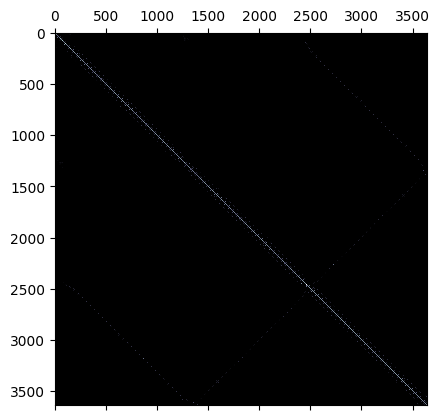

In [39]:
if sparse:
    plt.matshow(np.abs(A.toarray()), cmap='bone')
else:
    plt.matshow(np.abs(A), cmap='bone')
# for y_ in range(0,NDOF,Nth):
#     plt.hlines(y=y_,xmin=0,xmax=NDOF,colors='r')
#     plt.vlines(x=y_,ymin=0,ymax=NDOF,colors='r')


In [40]:
t = 3
B = AssembleRHS(V, Edges, kappa_e, H, d_2=d_2, t=t)

In [41]:
# d_2 = 0.5
# A_full = AssembleMatrix(V, Edges, Np=NP, d_2=d_2, fullsides=True, sparse=sparse)

# A_broken = AssembleMatrix(V, Edges, Np=NP, d_2=d_2, fullsides=False, sparse=sparse)
# plt.plot(np.abs(A_full - A_broken).toarray().ravel()[:1000])

In [42]:
#DOFs = np.linalg.solve(A,B)
from scipy.sparse.linalg import bicgstab 
from scipy.sparse.linalg import spsolve 
A = A.tocsc()
# DOFs, _ = bicgstab(A,B)
DOFs = spsolve(A,B)
f = TrefftzFunction(V,DOFs)

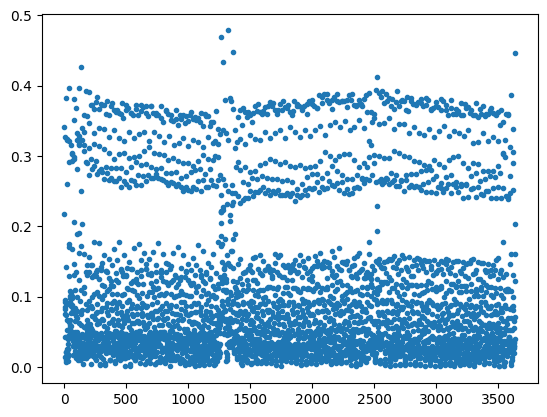

In [43]:
plt.plot(np.abs(DOFs),'.')

In [44]:
Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(-H,H,Ny)
X, Y = np.meshgrid(x,y)

Z =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])


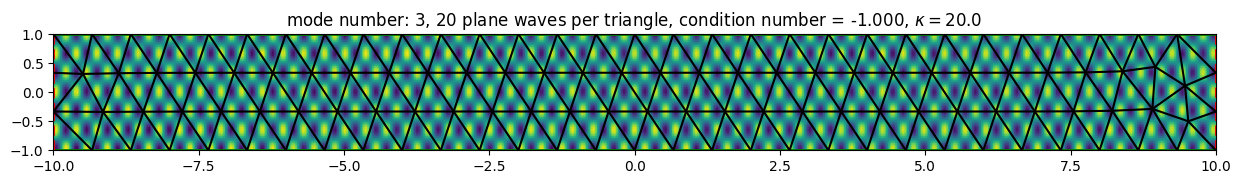

In [45]:
_, ax = plt.subplots( figsize=(15,3))

ax.imshow(np.real(Z), origin="lower", extent=[-R,R,-H,H])
#v = 1
#ax.imshow(np.real(Z), origin="lower", extent=[-R,R,-H,H], vmin=-v, vmax=v)

checkLabels(Edges, ax)
ax.axis('square')
ax.set_xlim([-R,R])
ax.set_ylim([-H,H])
plt.title(f'mode number: {t}, {Nth} plane waves per triangle, condition number = {Ncond: .3f}, $\\kappa={kappa_e:.1f}$')

save = False
if save:
    plt.savefig(f'test_{t}_{Nth}_d2.png')

In [46]:
# from exact_solutions import exact_sound_soft
# Z_exact = exact_sound_soft(X,Y,kappa_e, H, rad=rad, c=c, theta_inc=0, M = 40, N = 15)

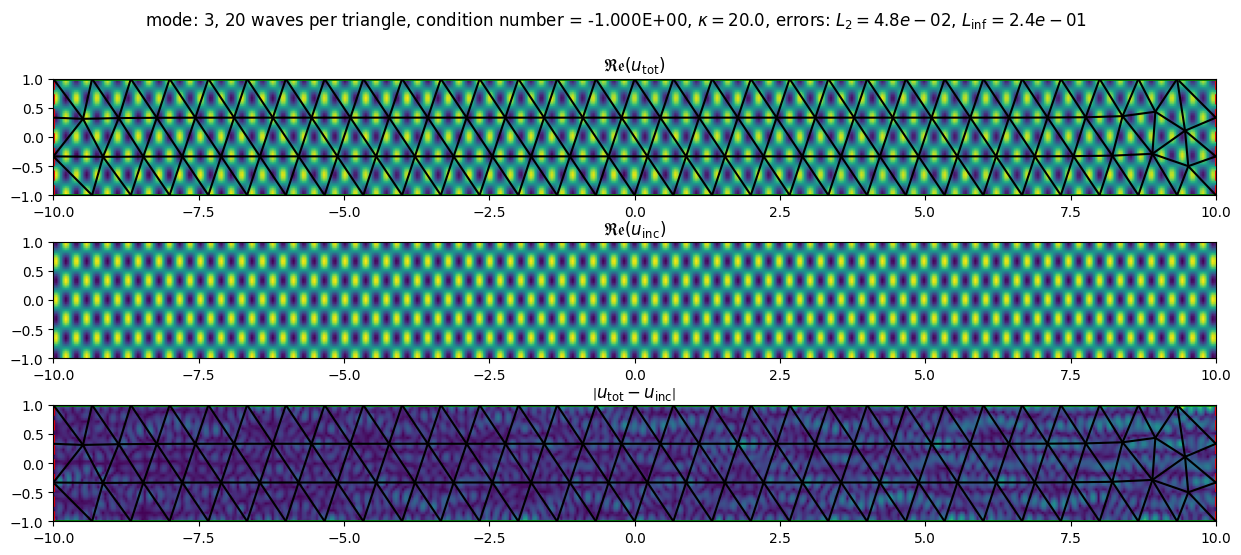

In [47]:
fig, ax = plt.subplots( nrows = 3, figsize=(15,6))

ax[0].imshow(np.real(Z), origin="lower", extent=[-R,R,-H,H])

checkLabels(Edges, ax[0])
ax[0].axis('square')
ax[0].set_xlim([-R,R])
ax[0].set_ylim([-H,H])

Z_inc = np.exp(1j*np.sqrt(complex(kappa_e**2 - (t*np.pi/H)**2))*X)*np.cos(t*np.pi*Y/H)
Z_exact = Z_inc
diff = np.where( (X-c[0])**2 + (Y-c[1])**2> rad**2, np.abs(Z - Z_exact), 0.)

L2_err = np.sqrt(np.mean(diff**2))
L_inf_err = np.max(diff)


ax[1].imshow(np.real(Z_exact), origin="lower", extent=[-R,R,-H,H])

# checkLabels(Edges, ax[1])
ax[1].axis('square')
ax[1].set_xlim([-R,R])
ax[1].set_ylim([-H,H])



ax[2].imshow(np.abs(Z-Z_exact), origin="lower", extent=[-R,R,-H,H])

checkLabels(Edges, ax[2])
ax[2].axis('square')
ax[2].set_xlim([-R,R])
ax[2].set_ylim([-H,H])

fig.suptitle(f'mode: {t}, {Nth} waves per triangle, condition number = {Ncond: .3E}, $\\kappa={kappa_e:.1f}$, errors: $L_2={L2_err:.1e}$, $L_\\inf={L_inf_err:.1e}$')
ax[0].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$')
ax[1].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{inc}\\right)$')
ax[2].set_title('$\\left\\vert u_\\mathrm{tot}-u_\\mathrm{inc}\\right\\vert$')

save = False
if save:
    plt.savefig(f'mode_{t}_{Nth}_no_d2_no_wave_in_basis.png')

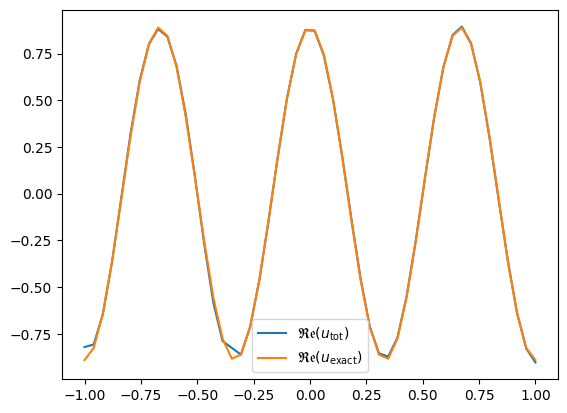

In [48]:
plt.plot(y,np.real(Z[:,0]), label='$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$')
plt.plot(y,np.real(Z_exact[:,0]), label='$\\mathfrak{Re}\\left(u_\\mathrm{exact}\\right)$')

plt.legend()


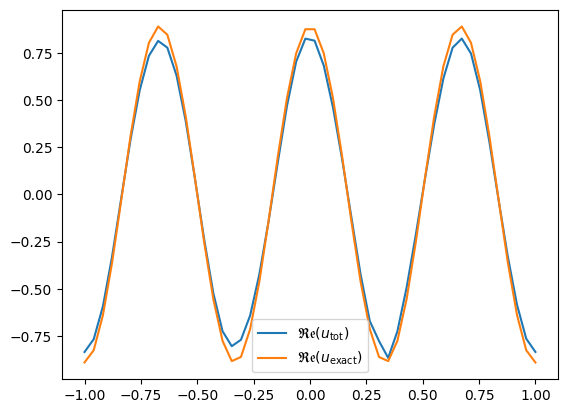

In [49]:
plt.plot(y,np.real(Z[:,-1]), label='$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$')
plt.plot(y,np.real(Z_exact[:,-1]), label='$\\mathfrak{Re}\\left(u_\\mathrm{exact}\\right)$')

plt.legend()


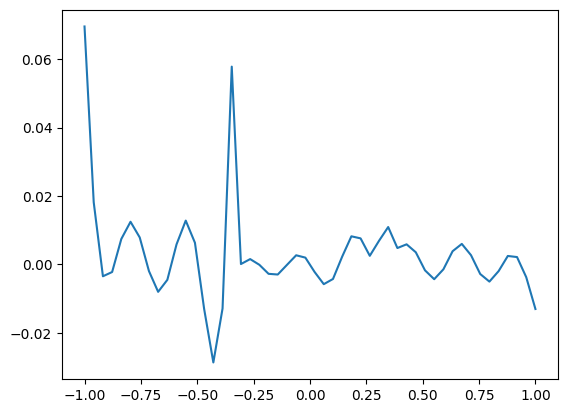

In [50]:
plt.plot(y,np.real((Z-Z_exact)[:,0]), label='$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$')
